In [1]:
!gdown -q 1gjEgFKrlBo2PgFSqi23-u5K3uIAr0AF5

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_video(video_path):
    """Load video frames and grayscale versions."""
    cap = cv2.VideoCapture(str(video_path))
    frames, gray_frames = [], []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        gray_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
    cap.release()
    print(f"Loaded {len(frames)} frames from {video_path}")
    return frames, gray_frames

In [4]:
def align_frames(frames, gray_frames, reference_idx=0, nfeatures=1000):
    """Align frames to reference using ORB + homography."""
    h, w = gray_frames[0].shape
    reference = gray_frames[reference_idx]
    orb = cv2.ORB_create(nfeatures=nfeatures)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    kp_ref, des_ref = orb.detectAndCompute(reference, None)

    aligned = []
    for i, (f, g) in enumerate(zip(frames, gray_frames)):
        if i == reference_idx:
            aligned.append(f)
            continue
        kp, des = orb.detectAndCompute(g, None)
        if des is not None and des_ref is not None:
            matches = bf.match(des_ref, des)
            matches = sorted(matches, key=lambda x: x.distance)
            if len(matches) > 10:
                top = matches[:100]
                src_pts = np.float32([kp_ref[m.queryIdx].pt for m in top]).reshape(-1, 1, 2)
                dst_pts = np.float32([kp[m.trainIdx].pt for m in top]).reshape(-1, 1, 2)
                H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
                if H is not None:
                    aligned.append(cv2.warpPerspective(f, H, (w, h)))
                    continue
        aligned.append(f)
    return aligned

In [5]:
def create_min_max_composite(frames):
    """Return min and max grayscale composites."""
    arr = np.array([cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) if f.ndim == 3 else f for f in frames])
    return np.min(arr, axis=0).astype(np.uint8), np.max(arr, axis=0).astype(np.uint8)

In [6]:
def separate_layers(aligned_frames, iterations=3):
    """Iterative constrained separation (simple conservative updates)."""
    transmitted, max_comp = create_min_max_composite(aligned_frames)
    reflection = cv2.subtract(max_comp, transmitted)

    L1 = transmitted.astype(np.float32) / 255.0
    L2 = reflection.astype(np.float32) / 255.0

    for _ in range(iterations):
        for frame in aligned_frames:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
            combined = L1 + L2
            residual = gray - combined
            weight1 = 1.0 / (L1 + 0.01)
            weight2 = 1.0 / (L2 + 0.01)
            total = weight1 + weight2
            L1 += 0.3 * residual * (weight1 / total)
            L2 += 0.3 * residual * (weight2 / total)
            L1 = np.clip(L1, 0.0, 1.0)
            L2 = np.clip(L2, 0.0, 1.0)

            combined = L1 + L2
            mask = combined > 1.0
            if np.any(mask):
                scale = 1.0 / combined[mask]
                L1[mask] *= scale
                L2[mask] *= scale

    return (L1 * 255).astype(np.uint8), (L2 * 255).astype(np.uint8)

In [7]:
def process_video(video_path, reference_idx=None):
    frames, gray_frames = load_video(video_path)
    if not frames:
        raise RuntimeError("No frames loaded.")
    if reference_idx is None:
        reference_idx = len(frames) // 2

    print("Aligning frames...")
    aligned = align_frames(frames, gray_frames, reference_idx=reference_idx)

    print("Separating layers...")
    transmitted, reflection = separate_layers(aligned, iterations=3)

    return transmitted, reflection, aligned

In [13]:
def visualize_results(transmitted, reflection, first_frame, out_path="reflection_removal_results.png"):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes[0, 0].imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title("(a) Original Frame")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(cv2.cvtColor(transmitted, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title("(b) Transmitted Layer (Photo)")
    axes[0, 1].axis("off")

    reflection_enh = cv2.convertScaleAbs(reflection, alpha=2.0)
    axes[1, 0].imshow(cv2.cvtColor(reflection_enh, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title("(c) Reflection (Enhanced)")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(cv2.cvtColor(reflection, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title("(d) Reflection (Original)")
    axes[1, 1].axis("off")

    plt.tight_layout()
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    return fig

In [10]:
video_path = "picture_frame.mp4"
transmitted, reflection, aligned_frames = process_video(video_path)

Loaded 391 frames from picture_frame.mp4
Aligning frames...
Separating layers...


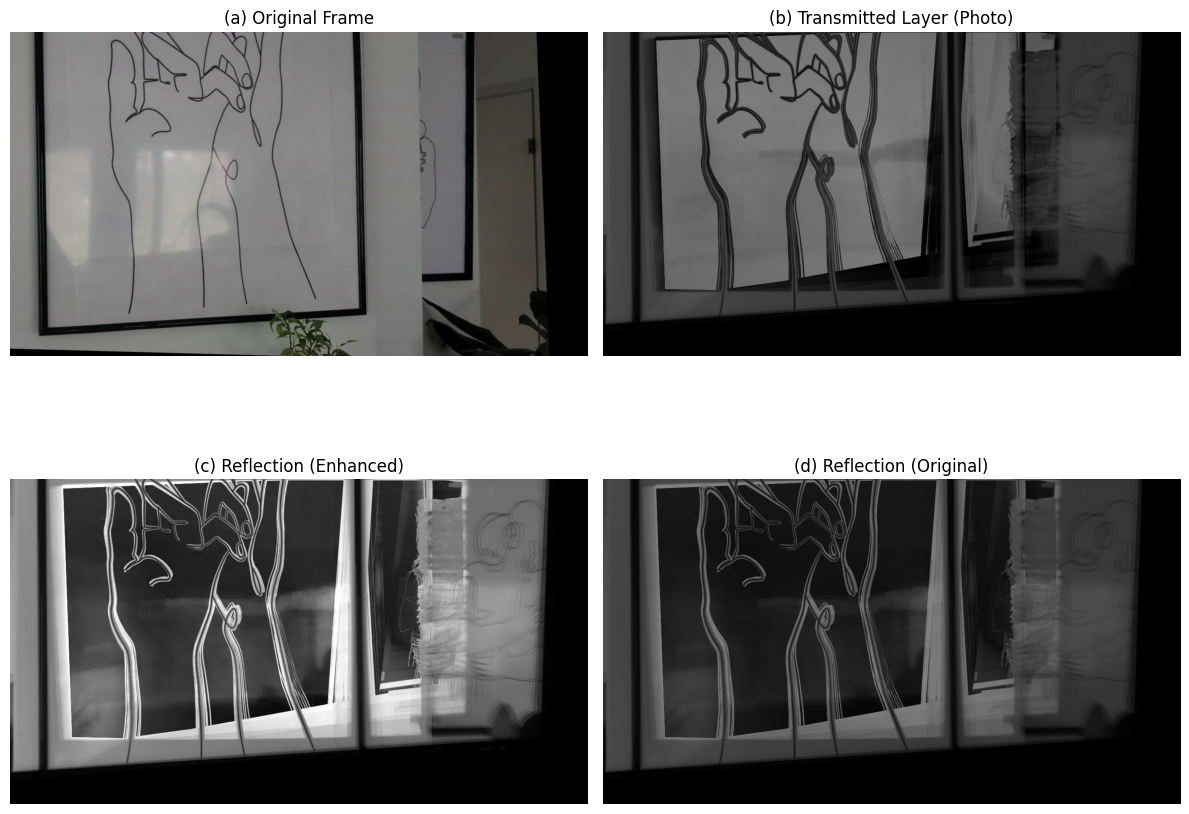

True

In [14]:
visualize_results(transmitted, reflection, aligned_frames[0])

cv2.imwrite("transmitted_layer.png", transmitted)
cv2.imwrite("reflection_layer.png", reflection)